In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 294 kB 2.7 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statannotations 0.6.0 requires seaborn<0.12,>=0.9.0, but you have seaborn 0.13.0 which is incompatible.


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
#tf_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240613/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")
# virprobert_80_20_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split70-10-20_virprobert_classwise_auprc.csv")
# virprobert_70_30_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split60-10-30_virprobert_classwise_auprc.csv")
# virprobert_50_50_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split40-10-50_virprobert_classwise_auprc.csv")
# virprobert_40_60_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split30-10-60_virprobert_classwise_auprc.csv")

                                                 

virprobert_output_auprc_file_paths =  {
    "sl256st128_w3s5": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240905/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_se_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    #"sl256st64_w5s2": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240906/host_multi/few_shot_learning/fsl_tr_w5s2q10_te_w5s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
}
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_non_idv_lt_1percent_prevalence.csv")

In [5]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n({v:.2f}%)" for k, v, in labels_counts.items()}
    labels_counts["Xiphophorus malinche x Xiphophorus birchmanni"] = "Xiphophorus birchmanni\n(0.02%)"
    return labels_counts

In [6]:
df = read_output_df(virprobert_output_auprc_file_paths)
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
dataset_df.shape

(16074, 12)

In [8]:
df["model"].unique()

array(['sl256st128_w3s5'], dtype=object)

In [9]:
df["class"].nunique()

291

In [10]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=True)
metadata_formatted

{'Cyprinus carpio': 'Cyprinus carpio\n(0.86%)',
 'Petroica australis': 'Petroica australis\n(0.85%)',
 'Felis catus': 'Felis catus\n(0.62%)',
 'Gopherus morafkai': 'Gopherus morafkai\n(0.61%)',
 'Peromyscus boylii': 'Peromyscus boylii\n(0.59%)',
 'Marmota flaviventris': 'Marmota flaviventris\n(0.57%)',
 'Bos taurus': 'Bos taurus\n(0.54%)',
 'Eptesicus fuscus': 'Eptesicus fuscus\n(0.53%)',
 'Macaca mulatta': 'Macaca mulatta\n(0.49%)',
 'Loxodonta africana': 'Loxodonta africana\n(0.45%)',
 'Mastomys natalensis': 'Mastomys natalensis\n(0.43%)',
 'Gymnorhina tibicen': 'Gymnorhina tibicen\n(0.41%)',
 'Eidolon helvum': 'Eidolon helvum\n(0.39%)',
 'Ailurus fulgens': 'Ailurus fulgens\n(0.37%)',
 'Sparus aurata': 'Sparus aurata\n(0.37%)',
 'Elephas maximus': 'Elephas maximus\n(0.36%)',
 'Oryzomys sp.': 'Oryzomys sp.\n(0.33%)',
 'Lates calcarifer': 'Lates calcarifer\n(0.33%)',
 'Bufo bufo': 'Bufo bufo\n(0.32%)',
 'Crocodylus porosus': 'Crocodylus porosus\n(0.32%)',
 'Rattus norvegicus': 'Rattus 

In [11]:
max([len(x) for x in metadata_formatted.values()])

61

In [12]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=False)
metadata_unformatted

{'Cyprinus carpio': 0.8599765651155006,
 'Petroica australis': 0.8536993639102779,
 'Felis catus': 0.6235353197187814,
 'Gopherus morafkai': 0.610980917308336,
 'Peromyscus boylii': 0.5900569132909274,
 'Marmota flaviventris': 0.5670405088717777,
 'Bos taurus': 0.5377469032474054,
 'Eptesicus fuscus': 0.5335621024439237,
 'Macaca mulatta': 0.48543689320388345,
 'Loxodonta africana': 0.4456812855708068,
 'Mastomys natalensis': 0.4331268831603616,
 'Gymnorhina tibicen': 0.4059256779377301,
 'Eidolon helvum': 0.38500167392032136,
 'Ailurus fulgens': 0.37244727150987617,
 'Sparus aurata': 0.36826247070639434,
 'Elephas maximus': 0.35989286909943086,
 'Oryzomys sp.': 0.33478406427854035,
 'Lates calcarifer': 0.33059926347505864,
 'Bufo bufo': 0.3180448610646133,
 'Crocodylus porosus': 0.31595246066287247,
 'Rattus norvegicus': 0.305490458654168,
 'Hypsugo savii': 0.305490458654168,
 'Equus caballus': 0.305490458654168,
 'Dipodomys merriami': 0.30339805825242716,
 'Crocodilurus amazonicus': 

In [13]:
len(metadata_formatted)

1299

In [14]:
classes = list(metadata_unformatted.keys())
classes

['Cyprinus carpio',
 'Petroica australis',
 'Felis catus',
 'Gopherus morafkai',
 'Peromyscus boylii',
 'Marmota flaviventris',
 'Bos taurus',
 'Eptesicus fuscus',
 'Macaca mulatta',
 'Loxodonta africana',
 'Mastomys natalensis',
 'Gymnorhina tibicen',
 'Eidolon helvum',
 'Ailurus fulgens',
 'Sparus aurata',
 'Elephas maximus',
 'Oryzomys sp.',
 'Lates calcarifer',
 'Bufo bufo',
 'Crocodylus porosus',
 'Rattus norvegicus',
 'Hypsugo savii',
 'Equus caballus',
 'Dipodomys merriami',
 'Crocodilurus amazonicus',
 'Tarsiger cyanurus',
 'Chelonia mydas',
 'Mus musculus',
 'Rhinolophus ferrumequinum',
 'Ovis aries',
 'Tursiops aduncus',
 'Tadarida brasiliensis',
 'Anas superciliosa',
 'Pteropus scapulatus',
 'Heloderma suspectum',
 'Squalius cephalus',
 'Oryctolagus cuniculus',
 'Coendou prehensilis',
 'Anas castanea',
 'Grus japonensis',
 'Amazona oratrix',
 'Callorhinus ursinus',
 'Phylloscopus inornatus',
 'Macaca fuscata',
 'Phrynocephalus erythrurus',
 'Hoplobatrachus rugulosus',
 'Pero

In [15]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Cyprinus carpio': 0,
 'Petroica australis': 1,
 'Felis catus': 2,
 'Gopherus morafkai': 3,
 'Peromyscus boylii': 4,
 'Marmota flaviventris': 5,
 'Bos taurus': 6,
 'Eptesicus fuscus': 7,
 'Macaca mulatta': 8,
 'Loxodonta africana': 9,
 'Mastomys natalensis': 10,
 'Gymnorhina tibicen': 11,
 'Eidolon helvum': 12,
 'Ailurus fulgens': 13,
 'Sparus aurata': 14,
 'Elephas maximus': 15,
 'Oryzomys sp.': 16,
 'Lates calcarifer': 17,
 'Bufo bufo': 18,
 'Crocodylus porosus': 19,
 'Rattus norvegicus': 20,
 'Hypsugo savii': 21,
 'Equus caballus': 22,
 'Dipodomys merriami': 23,
 'Crocodilurus amazonicus': 24,
 'Tarsiger cyanurus': 25,
 'Chelonia mydas': 26,
 'Mus musculus': 27,
 'Rhinolophus ferrumequinum': 28,
 'Ovis aries': 29,
 'Tursiops aduncus': 30,
 'Tadarida brasiliensis': 31,
 'Anas superciliosa': 32,
 'Pteropus scapulatus': 33,
 'Heloderma suspectum': 34,
 'Squalius cephalus': 35,
 'Oryctolagus cuniculus': 36,
 'Coendou prehensilis': 37,
 'Anas castanea': 38,
 'Grus japonensis': 39,
 'Ama

In [16]:
len(classes)

1299

In [17]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [18]:
df = df.replace({"class": metadata_formatted})

<Figure size 432x288 with 0 Axes>

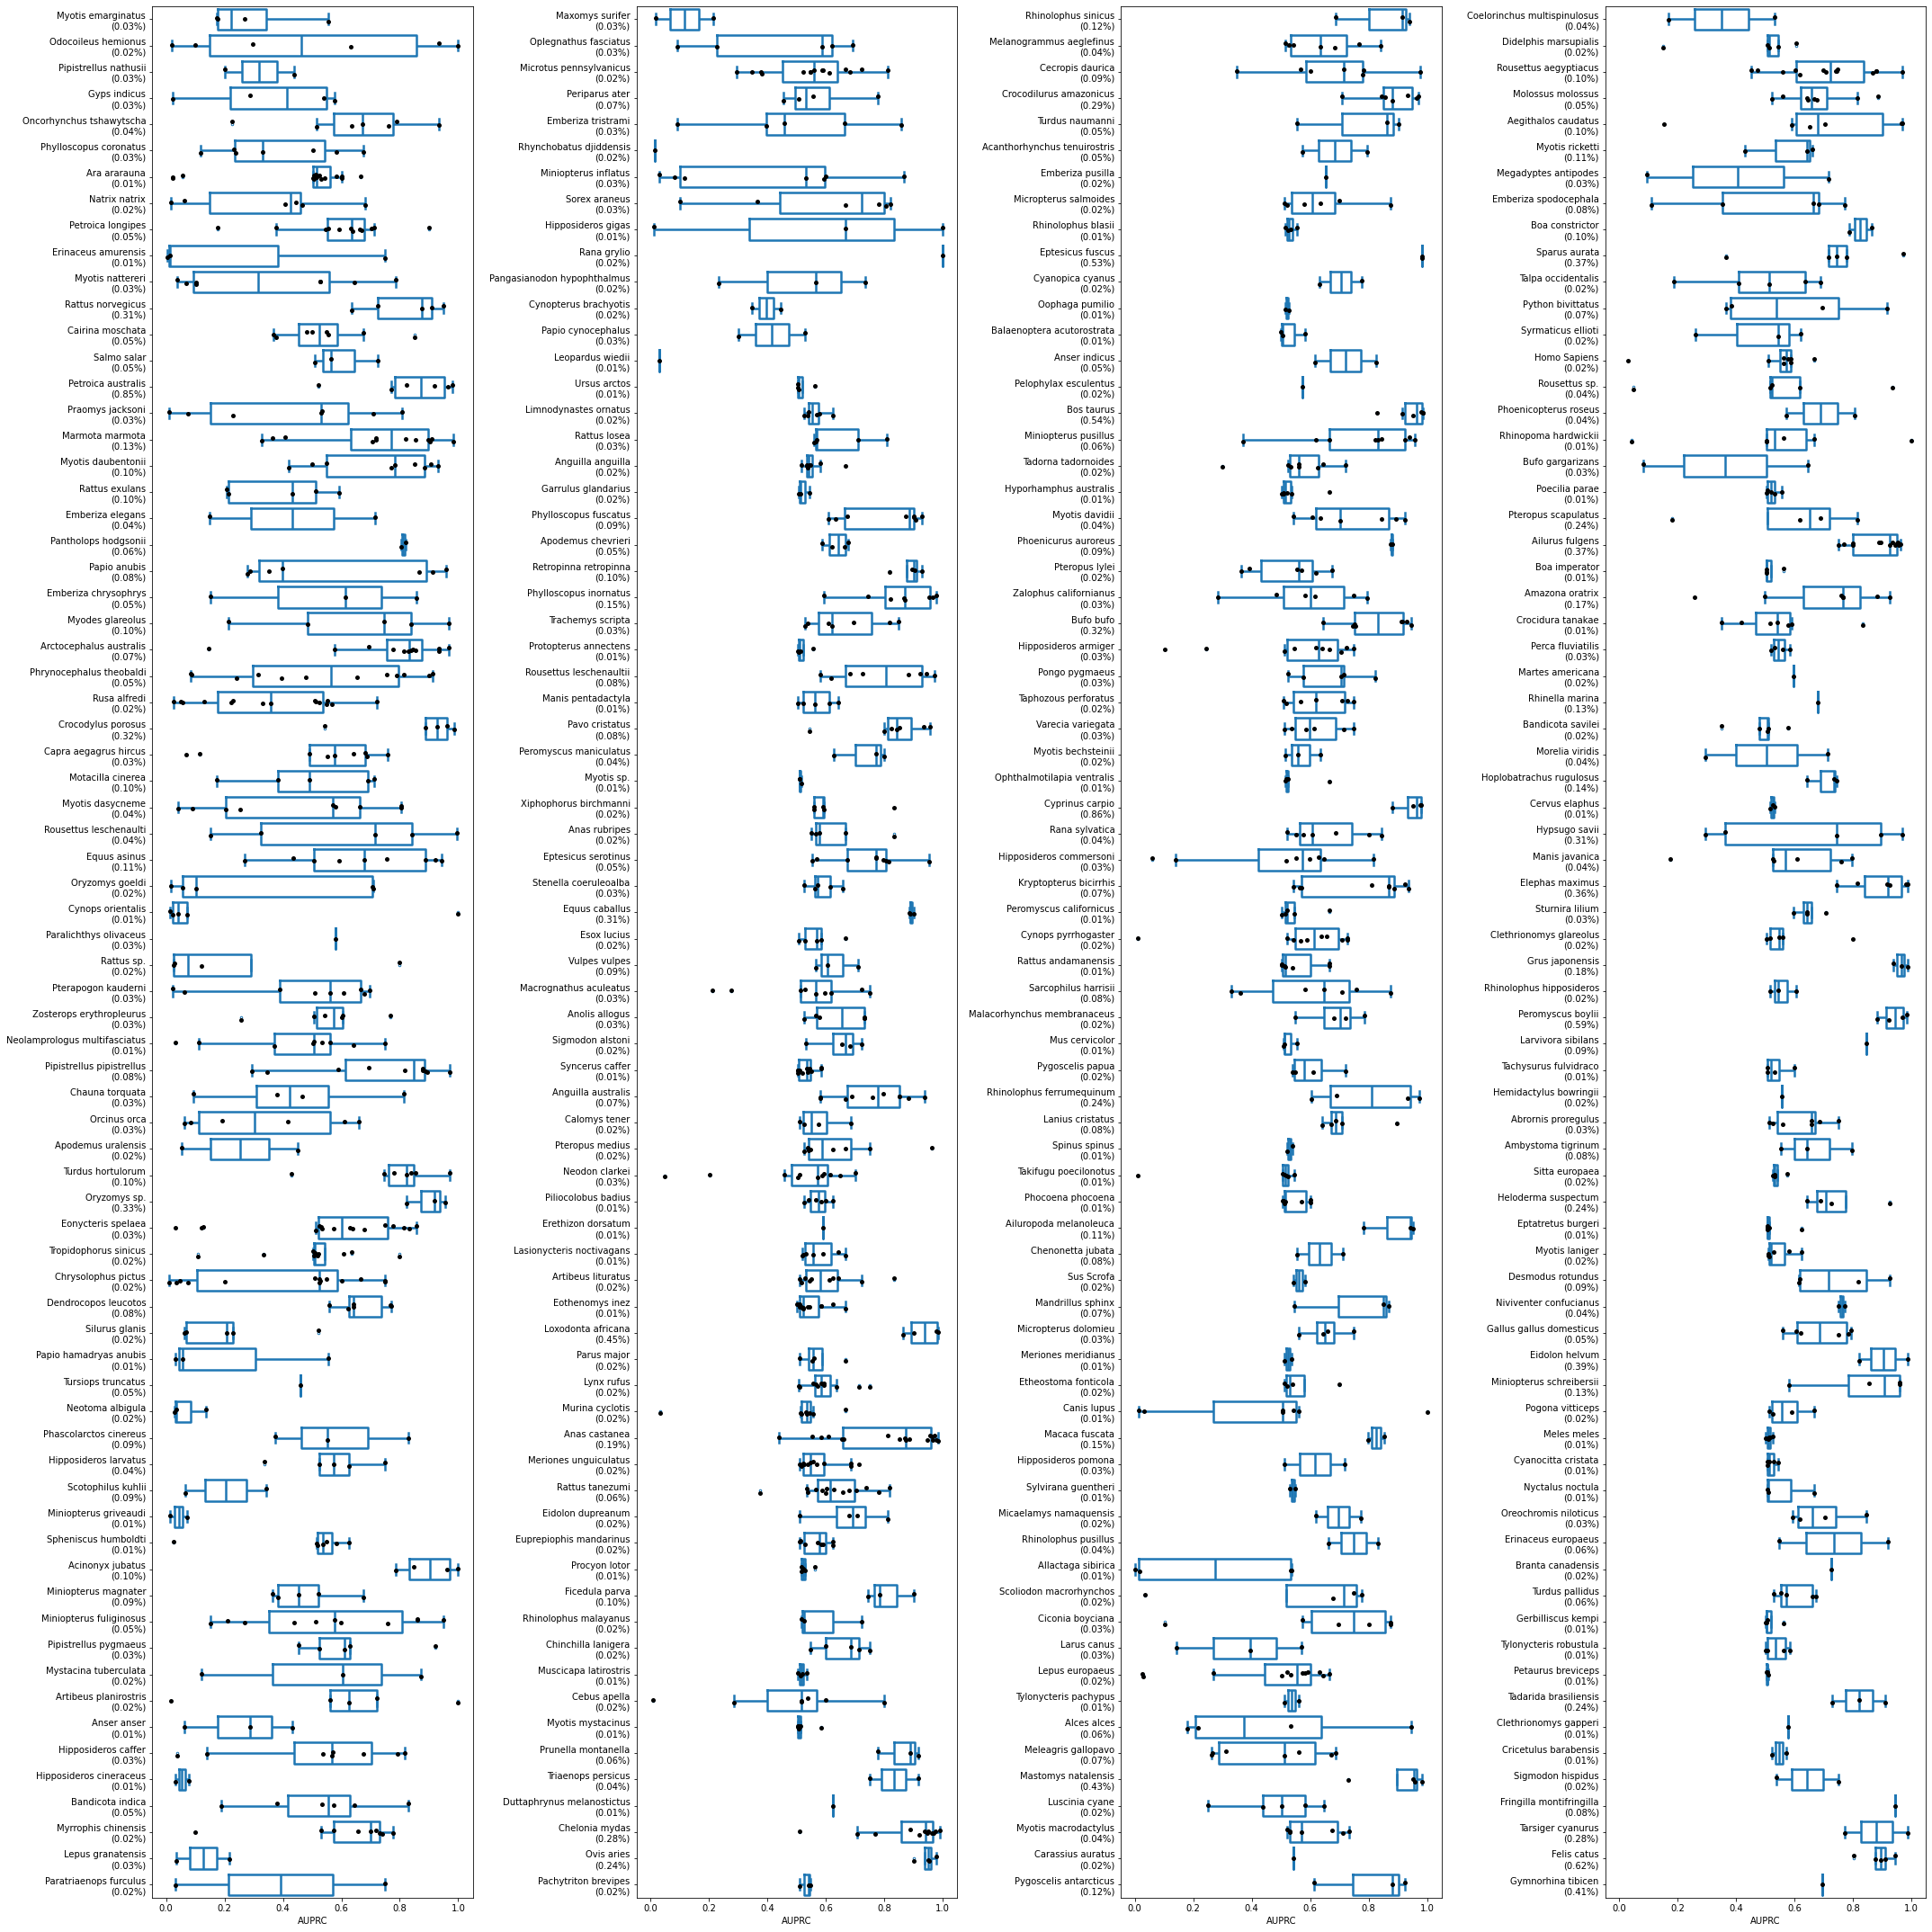

In [19]:
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15



plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 4, figsize=(30, 30), sharex=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})

df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
df = df.replace({"class": metadata_formatted})
classes = list(df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 4)

for i in range(4):
    
    #sns.violinplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", hue="model", ax=axs[i], split=True, orient="h", linewidth=2.5, fill=False,  order=bins[i])
    sns.boxplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", linewidth=2.5, fill=False, fliersize=2.5, order=bins[i])
    sns.stripplot(data=df[df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC")

plt.tight_layout(pad=.1)
plt.show()

In [20]:
metadata_formatted_inv_map = {v: k for k,v in metadata_formatted.items()}
metadata_formatted_prevalance_map = {k: metadata_unformatted[v]  for k,v in metadata_formatted_inv_map.items()}
metadata_formatted_prevalance_map

{'Cyprinus carpio\n(0.86%)': 0.8599765651155006,
 'Petroica australis\n(0.85%)': 0.8536993639102779,
 'Felis catus\n(0.62%)': 0.6235353197187814,
 'Gopherus morafkai\n(0.61%)': 0.610980917308336,
 'Peromyscus boylii\n(0.59%)': 0.5900569132909274,
 'Marmota flaviventris\n(0.57%)': 0.5670405088717777,
 'Bos taurus\n(0.54%)': 0.5377469032474054,
 'Eptesicus fuscus\n(0.53%)': 0.5335621024439237,
 'Macaca mulatta\n(0.49%)': 0.48543689320388345,
 'Loxodonta africana\n(0.45%)': 0.4456812855708068,
 'Mastomys natalensis\n(0.43%)': 0.4331268831603616,
 'Gymnorhina tibicen\n(0.41%)': 0.4059256779377301,
 'Eidolon helvum\n(0.39%)': 0.38500167392032136,
 'Ailurus fulgens\n(0.37%)': 0.37244727150987617,
 'Sparus aurata\n(0.37%)': 0.36826247070639434,
 'Elephas maximus\n(0.36%)': 0.35989286909943086,
 'Oryzomys sp.\n(0.33%)': 0.33478406427854035,
 'Lates calcarifer\n(0.33%)': 0.33059926347505864,
 'Bufo bufo\n(0.32%)': 0.3180448610646133,
 'Crocodylus porosus\n(0.32%)': 0.31595246066287247,
 'Rattus

In [21]:
df["prevalence"] = df["class"].apply(lambda x: metadata_formatted_prevalance_map[x])
df.head()

,class,auprc,itr,model,prevalence
0,Myotis emarginatus\n(0.03%),0.555556,0,sl256st128_w3s5,0.025109
1,Odocoileus hemionus\n(0.02%),0.934343,0,sl256st128_w3s5,0.023016
2,Pipistrellus nathusii\n(0.03%),0.438595,0,sl256st128_w3s5,0.025109
3,Gyps indicus\n(0.03%),0.286667,0,sl256st128_w3s5,0.025109
4,Oncorhynchus tshawytscha\n(0.04%),0.225962,0,sl256st128_w3s5,0.035571


In [22]:
mean_auprc_df = df[["model", "class", "auprc"]].groupby(["model", "class"]).agg("mean").reset_index()
mean_auprc_df["prevalance"] = mean_auprc_df["class"].apply(lambda x: metadata_formatted_prevalance_map[x])
mean_auprc_df

,model,class,auprc,prevalance
0,sl256st128_w3s5,Abrornis proregulus\n(0.03%),0.621145,0.025109
1,sl256st128_w3s5,Acanthorhynchus tenuirostris\n(0.05%),0.683824,0.052310
2,sl256st128_w3s5,Acinonyx jubatus\n(0.10%),0.897671,0.096250
3,sl256st128_w3s5,Aegithalos caudatus\n(0.10%),0.672432,0.098343
4,sl256st128_w3s5,Ailuropoda melanoleuca\n(0.11%),0.892413,0.108805
...,...,...,...,...
285,sl256st128_w3s5,Varecia variegata\n(0.03%),0.617952,0.029294
286,sl256st128_w3s5,Vulpes vulpes\n(0.09%),0.627391,0.089973
287,sl256st128_w3s5,Xiphophorus birchmanni\n(0.02%),0.628088,0.018832
288,sl256st128_w3s5,Zalophus californianus\n(0.03%),0.584986,0.031386


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

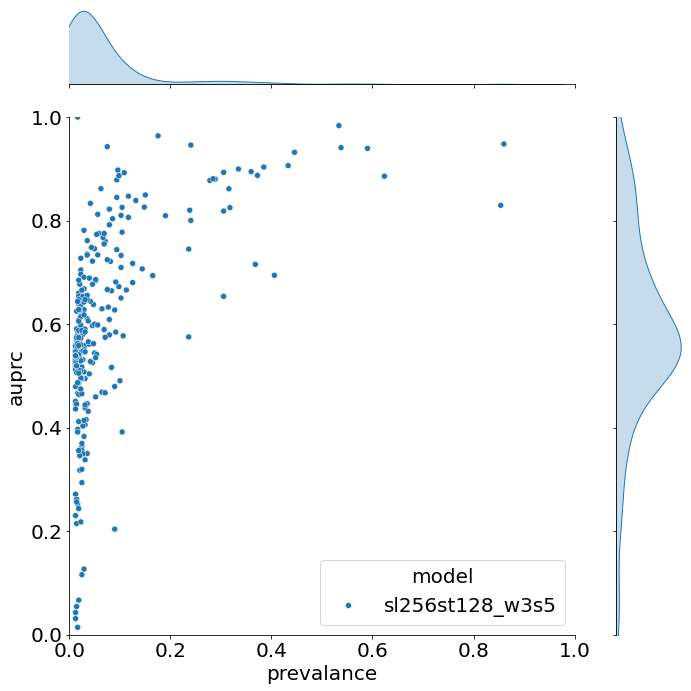

In [23]:
plt.clf()
plt.figure(figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})

ax = sns.jointplot(data=mean_auprc_df, x="prevalance", y="auprc", hue="model", height=10, ylim=(0, 1), xlim=(0, 1))

# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
#ax.set_xlabel("Class Prevalence")
#ax.set_ylabel("Mean AUPRC")
plt.show()

In [24]:
df.head()

,class,auprc,itr,model,prevalence
0,Myotis emarginatus\n(0.03%),0.555556,0,sl256st128_w3s5,0.025109
1,Odocoileus hemionus\n(0.02%),0.934343,0,sl256st128_w3s5,0.023016
2,Pipistrellus nathusii\n(0.03%),0.438595,0,sl256st128_w3s5,0.025109
3,Gyps indicus\n(0.03%),0.286667,0,sl256st128_w3s5,0.025109
4,Oncorhynchus tshawytscha\n(0.04%),0.225962,0,sl256st128_w3s5,0.035571
